# setup and imports

In [1]:
import fnmatch
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from ipywidgets import interactive
import numpy as np
import os
import glob
from scipy.ndimage import gaussian_filter as smooth
import platform

%run sessionlists
from VIGOR_utils import *
from VIGOR_plotting import *
from VIGOR_MODELS_Functions import *

plt.style.use('./Figures/paper.mplstyle')

In [2]:
#### Define folder with data 
if platform.system()=='Linux':
    root="/home/david/Desktop/ALLDATA"
    savePath="/home/david/Desktop/Save"
elif platform.system()=='Darwin':
    root="/Users/tom/Desktop/DATA"
    savePath="/Users/tom/Desktop/Save"
if 'COLAB_GPU' in os.environ:
    !gdown --id 1BSepSzm1-KQJlUvv8C23p_qyHvtzvrZ8
    !unzip -qq /content/code/sequencesALLDATA.zip
    root="/content/code/sequencesALLDATA"
    savePath="/content/Save"
    print("I'm running on Colab")
print("Path to data is: %s"%root)

retval = os.getcwd()
print("Current working directory: %s" % retval)
print("Save Path: ", savePath)

print(f'Found {len(glob.glob(root+"/*"))} rats in the data folder')

Path to data is: /home/david/Desktop/ALLDATA
Current working directory: /home/david/Desktop/code
Save Path:  /home/david/Desktop/Save
Found 34 rats in the data folder


In [3]:
rat_markers = {}
sequence = {}

# define brain status (lesion/CNO/intact) for each rat, used in plots
# needs to be properly implemented, setting is in behav_params for each session.
brainstatus = {'RatF00': 'normal', 'RatF01': 'normal', 'RatF02': 'normal',
               'RatM00': 'normal', 'RatM01': 'normal', 'RatM02': 'normal',
               'RatF32': 'normal', 'RatF33': 'normal',
               'RatM31': 'normal', 'RatM32': 'normal',
                'RatF42': 'normal', 'RatM40': 'normal', 'RatM43': 'normal',
                'RatF50': 'DMS', 'RatF51': 'DLS', 'RatF52': 'DLS',
               'RatM50': 'DMS', 'RatM51': 'DMS', 'RatM52': 'DLS', 'RatM53': 'normal', 'RatM54': 'normal'}

markers = {'normal': 'o', 'thcre': 'd', 'lesion': 'x', 'biglesion': 'X'}
lines = {'normal': '-', 'thcre': '--', 'lesion': ':', 'biglesion': '-.'}

# define list of rats to be analyzed

# INTACT RATS
animalList = ['RatF00', 'RatF01', 'RatF02', 'RatM00', 'RatM01', 'RatM02', 
            'RatF32', 'RatF33', 'RatM31', 'RatM32', 'RatF42', 'RatM40', 'RatM43', 
            'RatM53', 'RatM54']


for index, animal in enumerate(animalList):
    print(f'Loading data for {animal}')
    # define marker and color for each rat, used in plots
    if fnmatch.fnmatch(animal, 'RatF*'):
        rat_markers[animal]=['silver', 'o', lines[brainstatus[animal]]]
    elif fnmatch.fnmatch(animal, 'RatM*'):
        rat_markers[animal]=['silver', 'o', lines[brainstatus[animal]]]
    elif fnmatch.fnmatch(animal, 'Rat00*'):
        rat_markers[animal]=[(0.0, 0.0, 0.0), "$\u2426$",]
    else:
        print("error, this is not a rat you got here")

    if animal == 'RatM00':
        rat_markers[animal][0] = 'dodgerblue'
        
    for session in sorted(matchsession(animal, dist60+dist90+dist120 + TM20+TM10+TM2+TMrev2+TMrev10+TMrev20)):

        biglesion = True if 'L' in session else False
        sequence[animal, session] = get_from_pickle(root, animal[0:6], session, name="sequence.p", biglesion=biglesion)

 

Loading data for RatF00
Loading data for RatF01
Loading data for RatF02
Loading data for RatM00
Loading data for RatM01
Loading data for RatM02
Loading data for RatF32
Loading data for RatF33
Loading data for RatM31
Loading data for RatM32
Loading data for RatF42
Loading data for RatM40
Loading data for RatM43
Loading data for RatM53
Loading data for RatM54


In [4]:
def round_nearest(x, a=0.04):
    return np.around(x / a) * a

def generate_running_time(loc, scale, N=1):
    u = np.random.uniform(0, 1, int(N))
    res = np.tan(np.pi * (u - 0.5)) * scale + loc
    return round_nearest(res)

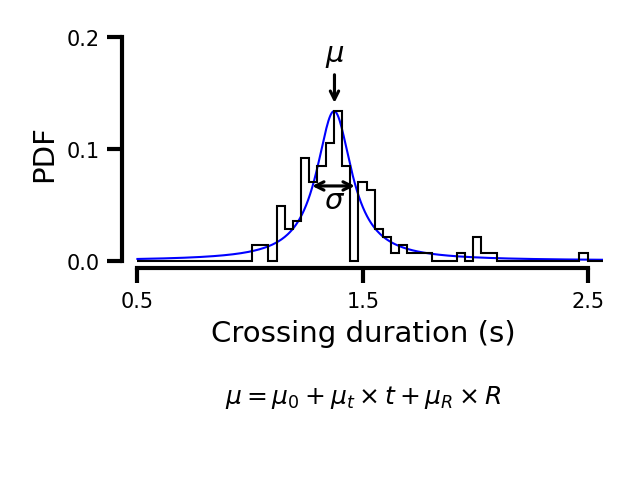

In [5]:
# crssing time first 10 min, all reward history pooled

def plot_mu(ax=None):
    if ax is None: 
        fig, ax = plt.subplots(1, 1, figsize=(2, 2))

    animal='RatM00'
    session='RatM00_2021_07_22_16_13_03'

    crossingtimes = prepare_data_running_times(sequence, [animal], [session])
    # crossingtimes = crossingtimes[animal][0][0]
    crossingtimes = [item for sublist in prepare_data_running_times(sequence, [animal], [session])[animal][0] for item in sublist]

    bins=np.linspace(0.5, 5, 125)
    ydata, xdata, _ = ax.hist(crossingtimes, bins=bins,
                    color='k', zorder=10, lw=.5,
                    #density=True,
                    weights=np.ones_like(crossingtimes) / len(crossingtimes),
                    histtype="step")
    
    x = np.linspace(0.5, 5, 1000)
    p = stats.cauchy.fit(crossingtimes)
    y = stats.cauchy.pdf(x, *p) /25
    ax.plot(x, y, color=plt.get_cmap('winter')(0), zorder=4, lw=0.5)

    ax.set_xlim(0.5, 2.5)
    ax.set_xticks([0.5, 1.5, 2.5])
    ax.set_ylim(0, .2)
    ax.set_yticks([0, .1, .2])
    ax.set_xlabel('Crossing duration (s)')
    ax.set_ylabel('PDF')


    x_peak = x[np.argmax(y)]
    y_peak = y[np.argmax(y)]

    # mu arrow
    ax.annotate(text='', xy=(x_peak, y_peak), xytext=(x_peak, y_peak+.04), arrowprops=dict(arrowstyle='->', lw=0.75), fontsize=5, zorder=5)
    ax.annotate(text=r'$\mu$', xy=(x_peak, y_peak), xytext=(x_peak, y_peak+.05), ha='center', va='center',
                xycoords='data', fontsize=7, zorder=5)
    
    half_max = np.max(y)/2
    idx = np.argwhere(np.diff(np.sign(y - half_max))).flatten()
    ax.annotate(text='', xy=(x[idx[0]], half_max), xytext=(x[idx[-1]], half_max), arrowprops=dict(arrowstyle='<->', lw=0.75, shrinkA=0, shrinkB=0), fontsize=5, zorder=5)
    ax.annotate(text=r'$\sigma$', xy=(x_peak, y_peak/2), xytext=(x_peak, y_peak/2), ha='center', va='top',
                xycoords='data', fontsize=7, zorder=5)
    space_axes(ax)

def equ_mu(ax=None):
    if ax is None: 
        fig, ax = plt.subplots(1, 1, figsize=(2, 2))
    ax.axis("off")
    ax.set_xlim(-1, 1)
    ax.set_ylim(-1, 1)
    ax.text(s=r'$\mu = \mu_0 + \mu_t \times t + \mu_R \times R$', x=0, y=.5, ha="center", va="center", fontsize=6)
    


fig, axs = plt.subplots(2, 1, figsize=(2, 1.5), gridspec_kw={'height_ratios': [3, 1]})
plot_mu(axs[0])
equ_mu(axs[1])

# 2A $\mu_0$

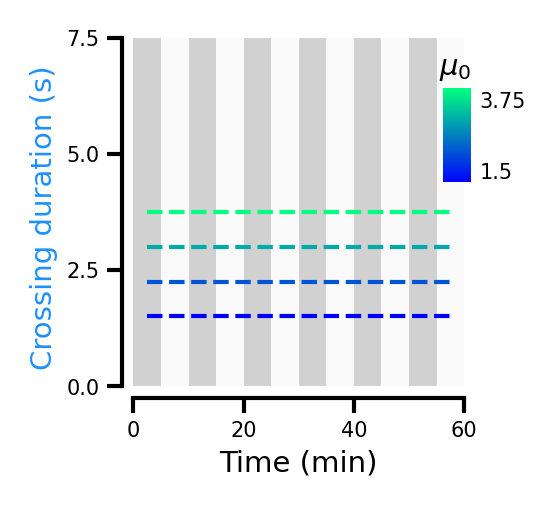

In [6]:
# plot variable median/mean fir each block
def Figure2A(ax=None):
    if ax is None:
        ax = plt.gca()

    rewardProbaBlock = [90, 10, 90, 10, 90, 10, 90, 10, 90, 10, 90, 10]
    blocks =  [[0, 300],  [300, 600],  [600, 900],  [900, 1200],
                [1200, 1500],  [1500, 1800],  [1800, 2100],  [2100, 2400],
                [2400, 2700],  [2700, 3000],  [3000, 3300],  [3300, 3600]]

    dummy_data = [2.25, 2.25, 2.25, 2.25, 2.25, 2.25, 2.25, 2.25, 2.25, 2.25, 2.25, 2.25]
    modifs = [-0.75, 0, 0.75, 1.5]
    
    cmap = plt.get_cmap('winter', len(modifs))
    for idx, modif in enumerate(modifs):
        ax.plot([(blocks[i][1] + blocks[i][0])/120 for i in range(0, len(blocks))], 
                [dummy_data[i] + modif for i in range(0, len(blocks))],
                color=cmap(idx), ls='--')

    for i in range(0, len(blocks)):
        ax.axvspan(blocks[i][0]/60, blocks[i][1]/60, ymin=1/30, ymax=1, color='grey', alpha=rewardProbaBlock[i]/250, lw=0)
    
    ax.set_xlabel("Time (min)")
    ax.set_ylabel("Crossing duration (s)", color='dodgerblue')
    ax.set_xlim(0, 60)
    ax.set_ylim(0, 7.5)
    ax.set_yticks([0, 2.5, 5, 7.5])
    space_axes(ax)


fig, ax = plt.subplots(1, 1, figsize=(cm2inch(4), cm2inch(4)))
Figure2A(ax=ax)


l, b, h, w = 0.9, .65, 0.2, 0.06
ax1 = fig.add_axes([l, b, w, h])

plot_colorbar(ax=ax1, fig=fig, label=r'$\mu_0$', cmap='winter', labels=[1.5, 0, 3.75])

# 2B $\mu_t$

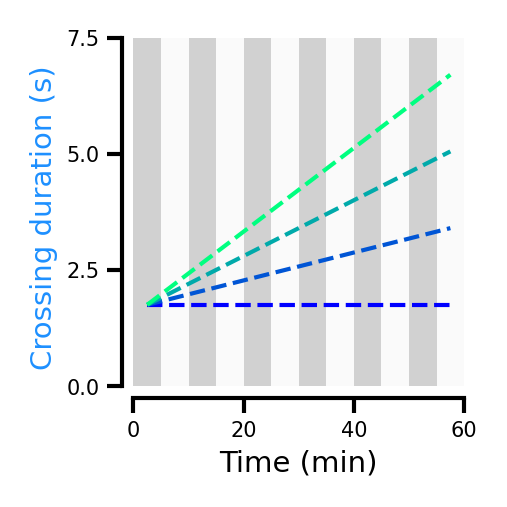

In [7]:
# plot variable median/mean fir each block
def Figure2B(ax=None):

    if ax is None:
        ax = plt.gca()

    rewardProbaBlock = [90, 10, 90, 10, 90, 10, 90, 10, 90, 10, 90, 10]
    blocks =  [[0, 300],  [300, 600],  [600, 900],  [900, 1200],
                [1200, 1500],  [1500, 1800],  [1800, 2100],  [2100, 2400],
                [2400, 2700],  [2700, 3000],  [3000, 3300],  [3300, 3600]]

    dummy_data = [1.75, 1.75, 1.75, 1.75, 1.75, 1.75, 1.75, 1.75, 1.75, 1.75, 1.75, 1.75]
    modifs = [0, 0.15, .3, .45]
    cmap = plt.get_cmap('winter', len(modifs))
    
    for idx, modif in enumerate(modifs):
        ax.plot([(blocks[i][1] + blocks[i][0])/120 for i in range(0, len(blocks))], 
                [dummy_data[i] + (i*modif) for i in range(0, len(blocks))],
                color=cmap(idx), ls='--')

    for i in range(0, len(blocks)):
        ax.axvspan(blocks[i][0]/60, blocks[i][1]/60, ymin=1/30, ymax=1, color='grey', alpha=rewardProbaBlock[i]/250, lw=0)
    
    ax.set_xlabel("Time (min)")
    ax.set_ylabel("Crossing duration (s)", color='dodgerblue')
    ax.set_xlim(0, 60)
    ax.set_ylim(0, 7.5)
    ax.set_yticks([0, 2.5, 5, 7.5])
    space_axes(ax)


fig, ax = plt.subplots(1, 1, figsize=(cm2inch(4), cm2inch(4)))
Figure2B(ax=ax)

# 2C $\mu_R$

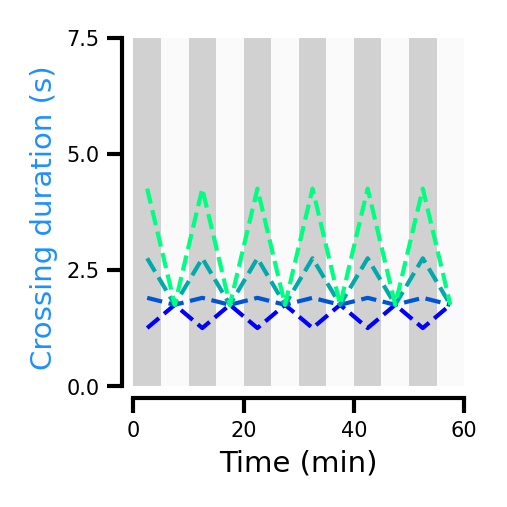

In [8]:
# plot variable median/mean fir each block
def Figure2C(ax=None):

    if ax is None:
        ax = plt.gca()

    rewardProbaBlock = [90, 10, 90, 10, 90, 10, 90, 10, 90, 10, 90, 10]
    blocks =  [[0, 300],  [300, 600],  [600, 900],  [900, 1200],
                [1200, 1500],  [1500, 1800],  [1800, 2100],  [2100, 2400],
                [2400, 2700],  [2700, 3000],  [3000, 3300],  [3300, 3600]]

    # dummy_data = [1.75, 2.7, 1.75, 2.75, 1.75, 2.75, 1.75, 2.7, 1.75, 2.75, 1.75, 2.80]

    dummy_data = [1.75, 1.75, 1.75, 1.75, 1.75, 1.75, 1.75, 1.75, 1.75, 1.75, 1.75, 1.75]
    modifs = [-.5, .15, 1, 2.5]
    cmap = plt.get_cmap('winter', len(modifs))

    for idx, modif in enumerate(modifs):
        
        ax.plot([(blocks[i][1] + blocks[i][0])/120 for i in range(0, len(blocks))], 
                [dummy_data[i] + modif if i % 2 == 0 else dummy_data[i] for i in range(0, len(blocks)) ],
                color=cmap(idx), ls='--')

    
    dummy_data = [1.25, 1.7, 1.2, 1.75, 1.2, 1.75, 1.25, 1.7, 1.30, 1.75, 1.25, 1.80]
 
    
    dummy_data = [1.25, 4.2, 1.2, 4.25, 1.2, 4.25, 1.25, 4.2, 1.30, 4.25, 1.25, 4.30] 


    for i in range(0, len(blocks)):
        ax.axvspan(blocks[i][0]/60, blocks[i][1]/60, ymin=1/30, ymax=1, color='grey', alpha=rewardProbaBlock[i]/250, lw=0)

    ax.set_xlabel("Time (min)")
    ax.set_ylabel("Crossing duration (s)", color='dodgerblue')
    ax.set_xlim(0, 60)
    ax.set_ylim(0, 7.5)
    ax.set_yticks([0, 2.5, 5, 7.5])
    space_axes(ax)

fig, ax = plt.subplots(1, 1, figsize=(cm2inch(4), cm2inch(4)))
Figure2C(ax=ax)

# 2D model + data

1.3731192071741753 0.0612856829746447 0.00633329065966956 0.0 0.0 0.0


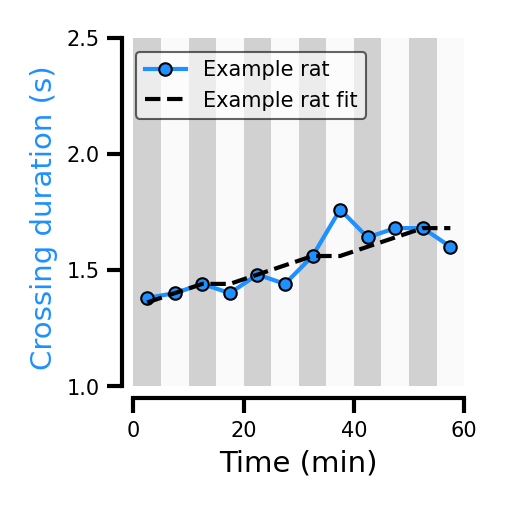

In [9]:
# plot variable median/mean fir each block
def Figure2D(ax=None):
    if ax is None:
        ax = plt.gca()

    rewardProbaBlock = [90, 10, 90, 10, 90, 10, 90, 10, 90, 10, 90, 10]
    blocks =  [[0, 300],  [300, 600],  [600, 900],  [900, 1200],
                [1200, 1500],  [1500, 1800],  [1800, 2100],  [2100, 2400],
                [2400, 2700],  [2700, 3000],  [3000, 3300],  [3300, 3600]]

    dummy_data = [1.25, 2.25, 1.5, 2.75, 2, 3.5, 2.4, 4.2, 3.2, 5.2, 3.5, 6.3]
    # ax.plot([(blocks[i][1] + blocks[i][0])/120 for i in range(0, len(blocks))], 
    #         [dummy_data[i] for i in range(0, len(blocks))],  # or use median
    #         # marker='o', ms=3, 
    #         color='dodgerblue', 
    #         zorder=4, markeredgecolor='k', markeredgewidth=0.5,
    #         ls='--', label='Synthetic data')
    
    for i in range(0, len(blocks)):
        ax.axvspan(blocks[i][0]/60, blocks[i][1]/60, ymin=1/30, ymax=1, color='grey', alpha=rewardProbaBlock[i]/250, lw=0)
    
    ax.set_xlabel("Time (min)")
    ax.set_ylabel("Crossing duration (s)", color='dodgerblue')
    ax.set_xlim(0, 60)
    ax.set_ylim(1, 2.5)
    ax.set_yticks([1, 1.5, 2, 2.5])
    space_axes(ax)


    # experimental rat data

    root = "/home/david/Desktop/ALLDATA"
    animal='RatM00'
    session='RatM00_2021_07_22_16_13_03'

    _params = get_from_pickle(root, animal, session, name="params.p")
    blocks = _params['blocks']
    rewardProbaBlock = _params['rewardProbaBlock']
    example_runningTimeInLeftBin, example_runningTimeInRightBin = get_from_pickle(root, animal, session, name="timeRun.p")
    data = [example_runningTimeInLeftBin[i]+example_runningTimeInRightBin[i] for i in range(0, 12)]

    ax.plot([(blocks[i][1] + blocks[i][0])/120 for i in range(0, len(blocks))], 
            [np.median(data[i]) for i in range(0, len(blocks))],  # or use median
            marker='o', ms=3, color='dodgerblue', 
            zorder=4, markeredgecolor='k', markeredgewidth=0.5, alpha=1, label='Example rat')


    # fit, generate samples from distribution with fit parameters, take median
    N_bins = 6
    N_avg = 4
    ex_mu, ex_mu_t, ex_mu_R, ex_sigma, ex_sigma_t, ex_sigma_R = pickle.load(open("picklejar/crossing_time_fit_example_session.p", "rb"))
    print(ex_mu, ex_mu_t, ex_mu_R, ex_sigma, ex_sigma_t, ex_sigma_R)
    MU = np.zeros((N_bins, N_avg))
    SIGMA = np.zeros((N_bins, N_avg))

    for bin in range(N_bins):
        for avg in range(N_avg):
            MU[bin, avg] = ex_mu + bin*ex_mu_t + avg*ex_mu_R
            SIGMA[bin, avg] = ex_sigma + bin*ex_sigma_t + avg*ex_sigma_R

    m = []
    s = []
    for i in range(6):
        m.append((.9*MU[i][0] + 0.1*MU[i][1]))
        m.append((.9*MU[i][-1] + 0.1*MU[i][-2]))
        s.append((.9*SIGMA[i][0] + 0.1*SIGMA[i][1]))
        s.append((.9*SIGMA[i][-1] + 0.1*SIGMA[i][-2]))

    res = [np.median(generate_running_time(m[i], 0*s[i], 1000)) for i in range(12)]
    
    ax.plot([(blocks[i][1] + blocks[i][0])/120 for i in range(0, len(blocks))],
            [res[i] for i in range(0, len(blocks))],
            color='k', ls='--', label='Example rat fit', zorder=5)


    handles, labels = ax.get_legend_handles_labels()
    unique = [(h, l) for i, (h, l) in enumerate(zip(handles, labels)) if l not in labels[:i]]
    ax.legend(*zip(*unique), loc='upper left', bbox_to_anchor=(0.01, 0.99), frameon=True, fontsize=5, markerscale=1, edgecolor='k', facecolor='w').get_frame().set_linewidth(.5)


fig, ax = plt.subplots(1, 1, figsize=(cm2inch(4), cm2inch(4)))
Figure2D(ax=ax)

# 2E schematic distance

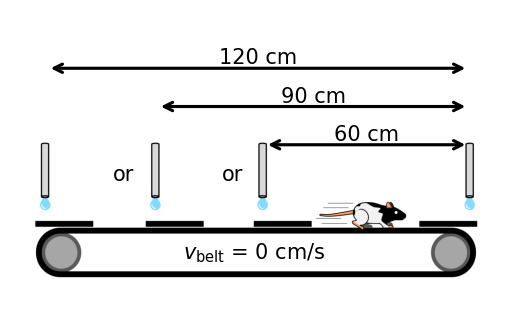

In [10]:
def Figure2E(ax=None, path=None):
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(5, 5))

    if path is None:
        path = "/home/david/Desktop/code/Figures/2Drun.png"

    img = plt.imread(path)
    img = img[300:2000, 150:3075]
    ax.imshow(img)
    ax.axis("off")
    ax.text(s=r'$v_{\mathrm{belt}}$ = 0 cm/s', x=img.shape[1]/2, y=1460, ha="center", va="center", fontsize=5)
    ax.text(s='or', x=610, y=950, ha="center", va="center", fontsize=5)
    ax.text(s='or', x=1325, y=950, ha="center", va="center", fontsize=5)

    ax.annotate(text='', xy=(1500, 750), xytext=(2900, 750), arrowprops=dict(arrowstyle='<->', lw=0.75), fontsize=5, zorder=5)
    ax.annotate(text='60 cm', xy=(0, 0), xytext=((1500+2900)/2, 750), ha='center', va='bottom', xycoords='data', fontsize=5, zorder=5)
    ax.annotate(text='', xy=(800, 500), xytext=(2900, 500), arrowprops=dict(arrowstyle='<->', lw=0.75), fontsize=5, zorder=5)
    ax.annotate(text='90 cm', xy=(0, 0), xytext=((800+2900)/2, 500), ha='center', va='bottom', xycoords='data', fontsize=5, zorder=5)
    ax.annotate(text='', xy=(80, 250), xytext=(2900, 250), arrowprops=dict(arrowstyle='<->', lw=0.75), fontsize=5, zorder=5)
    ax.annotate(text='120 cm', xy=(0, 0), xytext=((80+2900)/2, 250), ha='center', va='bottom', xycoords='data', fontsize=5, zorder=5)

fig, ax = plt.subplots(1, 1, figsize=(cm2inch(4), cm2inch(4)))
Figure2E(ax=ax)

# 2FGH fit result dist

In [11]:
def permutation_test_distances(var, shifty=0, h=None, dhs=[-0.05, -0.15], barh=-.05, ax=None, num_permutations=10000):
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(5, 5))

    data = np.array([[var[animal][cond] for cond in ['60', '90', '120']] for animal in animalList])
    p_value_60_90 = exact_mc_perm_test(data[:, 0], data[:, 1])
    p_value_60_120 = exact_mc_perm_test(data[:, 0], data[:, 2])
    p_value_90_120 = exact_mc_perm_test(data[:, 1], data[:, 2])

    print(f'p_value_60_90: {p_value_60_90}', f'p_value_60_120: {p_value_60_120}', f'p_value_90_120: {p_value_90_120}')
    if h is None:
        h = np.min([np.min(data[:, 0]), np.min(data[:, 1]), np.min(data[:, 2])])
        h1, h2, h3 = [h, h, h]
    else:
        h1, h2, h3 = h
    barplot_annotate_brackets(ax, 0, 1, stars(p_value_60_90), [0, 1, 2], [h1, h1, h1], dh=dhs[0]+shifty, barh=barh, maxasterix=None)
    barplot_annotate_brackets(ax, 0, 2, stars(p_value_60_120), [0, 1, 2], [h2, h2, h2], dh=dhs[1]+shifty, barh=barh, maxasterix=None)
    barplot_annotate_brackets(ax, 1, 2, stars(p_value_90_120), [0, 1, 2], [h3, h3, h3], dh=dhs[0]+shifty, barh=barh, maxasterix=None)


def permutation_test_vbelt(var, shifty=0, h=None, dhs=[-0.05, -0.15], barh=-.05, ax=None, num_permutations=10000):
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(5, 5))

    data = np.array([[var[animal][cond] for cond in ['20', '2', 'rev20']] for animal in animalList])
    p_value_20_2 = exact_mc_perm_test(data[:, 0], data[:, 1])
    p_value_2_rev20 = exact_mc_perm_test(data[:, 0], data[:, 2])
    p_value_20_rev20 = exact_mc_perm_test(data[:, 1], data[:, 2])

    print(f'p_value_20_0: {p_value_20_2}', f'p_value_0_rev20: {p_value_2_rev20}', f'p_value_20_rev20: {p_value_20_rev20}')
    if h is None:
        h = np.min([np.min(data[:, 0]), np.min(data[:, 1]), np.min(data[:, 2])])
        h1, h2, h3 = [h, h, h]
    else:
        h1, h2, h3 = h
    barplot_annotate_brackets(ax, 0, 1, stars(p_value_20_2), [0, 2, 4], [h1, h1, h1], dh=dhs[0]+shifty, barh=barh, maxasterix=None)
    barplot_annotate_brackets(ax, 0, 2, stars(p_value_2_rev20), [0, 2, 4], [h2, h2, h2], dh=dhs[1]+shifty, barh=barh, maxasterix=None)
    barplot_annotate_brackets(ax, 1, 2, stars(p_value_20_rev20), [0, 2, 4], [h3, h3, h3], dh=dhs[0]+shifty, barh=barh, maxasterix=None)


In [12]:
def plotmedian(var, ax=None, dist_or_tm='dist', do=False):
    if do:
        if ax is None:
            fig, ax = plt.subplots(1, 1, figsize=(cm2inch(4), cm2inch(4)))
        if dist_or_tm == 'dist':
            ax.plot([0, 1, 2], [np.median([var[animal]["60"] for animal in animalList]), 
                                np.median([var[animal]["90"] for animal in animalList]),
                                np.median([var[animal]["120"] for animal in animalList])],
                                color='k', label=f'Median (n={len(animalList)})')
        elif dist_or_tm == 'tm':
            ax.plot([0, 1, 2, 3, 4], [np.median([var[animal]["20"] for animal in animalList]), 
                                np.median([var[animal]["10"] for animal in animalList]),
                                np.median([var[animal]["2"] for animal in animalList]),
                                np.median([var[animal]["rev10"] for animal in animalList]),
                                np.median([var[animal]["rev20"] for animal in animalList])],
                                color='k')
        

p_value_60_90: 0.0 p_value_60_120: 0.0 p_value_90_120: 0.0
p_value_60_90: 0.003 p_value_60_120: 0.031 p_value_90_120: 0.8628
p_value_60_90: 0.12 p_value_60_120: 0.2943 p_value_90_120: 0.9863


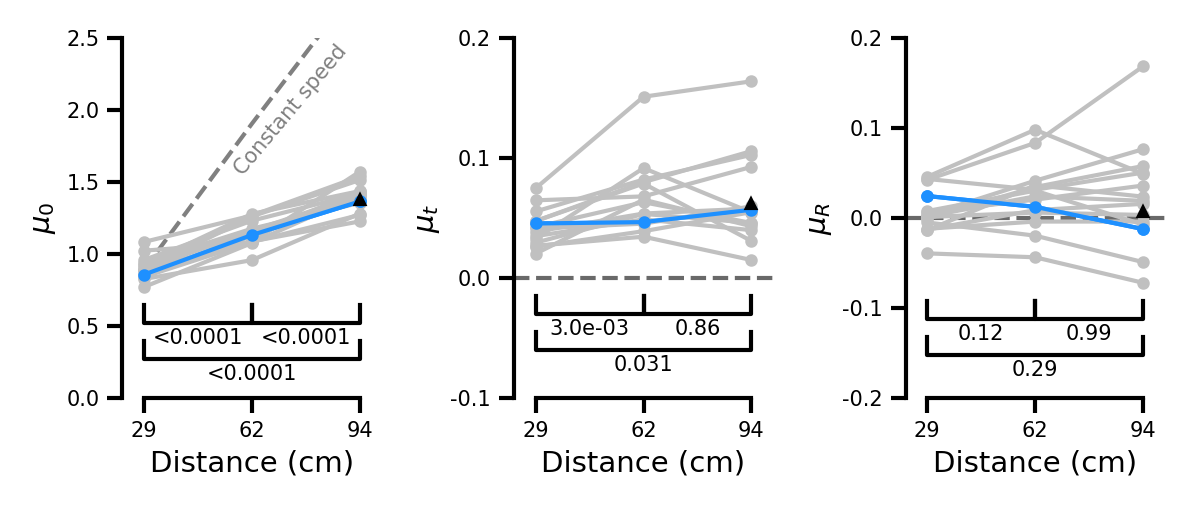

In [13]:
def Figure2F(ax=None):
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(5, 5))

    # ax.axhline(0, color='black', linestyle='--', linewidth=1, alpha=0.5, zorder=0)

    _, _, _, _, _, _, mu_0, _, _, _, _, _ = pickle.load(open("picklejar/intact_lesionFITS.p", "rb"))

    for animal in animalList:
        ax.plot([0, 1, 2], [mu_0[animal]["60"], mu_0[animal]["90"], mu_0[animal]["120"]], 
                        color=rat_markers[animal][0], marker=rat_markers[animal][1], 
                        markersize=2, linestyle=lines[brainstatus[animal]])
        
        if animal == 'RatM00':
            ax.plot([0, 1, 2], [mu_0[animal]["60"], mu_0[animal]["90"], mu_0[animal]["120"]], 
                        color=rat_markers[animal][0], marker=rat_markers[animal][1], 
                        markersize=2, linestyle=lines[brainstatus[animal]], zorder=5)

    
    ex_mu, ex_mu_t, ex_mu_R, ex_sigma, ex_sigma_t, ex_sigma_R = pickle.load(open("picklejar/crossing_time_fit_example_session.p", "rb"))
    ax.plot(2, ex_mu, color='black', marker='^', zorder=10, markersize=2, linewidth=0)
    
    
    ax.set_xlim(0, 2)
    ax.set_xticks([0, 1, 2])
    ax.set_xticklabels(["29", "62", "94"])
    ax.set_xlabel("Distance (cm)")

    ax.set_ylim(0, 2.5)
    ax.set_ylabel(r'$\mu_0$')
    space_axes(ax, y_ratio=0, x_ratio_left=.1, x_ratio_right=.1)

    avg60 = np.median([mu_0[animal]["60"] for animal in animalList])
    ax.plot([0, 1, 2], [avg60, (62/29)*avg60, (94/29)*avg60], color='gray', linestyle='--', linewidth=1, alpha=1, zorder=0,)
    ax.text(s='Constant speed', x=.8, y=2, ha="left", va="center", fontsize=5, color='gray', rotation=50)

    plotmedian(mu_0, ax=ax, dist_or_tm='dist')
    permutation_test_distances(mu_0, ax=ax, num_permutations=10000)
    
        
def Figure2G(ax=None):
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(5, 5))

    _, _, _, _, _, _, _, mu_t, _, _, _, _ = pickle.load(open("picklejar/intact_lesionFITS.p", "rb"))

    for animal in animalList:
        ax.plot([0, 1, 2], [mu_t[animal]["60"], mu_t[animal]["90"], mu_t[animal]["120"]], 
                        color=rat_markers[animal][0], label=animal, marker=rat_markers[animal][1], 
                        markersize=2, linestyle=lines[brainstatus[animal]])

        if animal == 'RatM00':
            ax.plot([0, 1, 2], [mu_t[animal]["60"], mu_t[animal]["90"], mu_t[animal]["120"]], 
                            color=rat_markers[animal][0], label=animal, marker=rat_markers[animal][1], 
                            markersize=2, linestyle=lines[brainstatus[animal]], zorder=10)
    
    ex_mu, ex_mu_t, ex_mu_R, ex_sigma, ex_sigma_t, ex_sigma_R = pickle.load(open("picklejar/crossing_time_fit_example_session.p", "rb"))
    ax.plot(2, ex_mu_t, color='black', marker='^', zorder=10, markersize=2, linewidth=0)
    
    
    ax.set_xlim(0, 2)
    ax.set_xticks([0, 1, 2])
    ax.set_xticklabels(["29", "62", "94"])
    ax.set_xlabel("Distance (cm)")

    ax.set_ylim(-0.1, .2)
    ax.set_yticks([-.1, 0, .1, .2])
    ax.set_ylabel(r'$\mu_t$')
    ax.axhline(0, color='dimgray', linestyle='--', linewidth=1, alpha=1, zorder=0)
    space_axes(ax, y_ratio=0, x_ratio_left=.1, x_ratio_right=.1)
    plotmedian(mu_t, ax=ax, dist_or_tm='dist')
    permutation_test_distances(mu_t, ax=ax, shifty=-.05, num_permutations=10000)


def Figure2H(ax=None):
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(5, 5))

    _, _, _, _, _, _, _, _, mu_R, _, _, _ = pickle.load(open("picklejar/intact_lesionFITS.p", "rb"))

    for animal in animalList:
        ax.plot([0, 1, 2], [mu_R[animal]["60"], mu_R[animal]["90"], mu_R[animal]["120"]], 
                        color=rat_markers[animal][0], label=animal, marker=rat_markers[animal][1], 
                        markersize=2, linestyle=lines[brainstatus[animal]])
        
        if animal == 'RatM00':
            ax.plot([0, 1, 2], [mu_R[animal]["60"], mu_R[animal]["90"], mu_R[animal]["120"]], 
                        color=rat_markers[animal][0], label=animal, marker=rat_markers[animal][1], 
                        markersize=2, linestyle=lines[brainstatus[animal]], zorder=10)


    ex_mu, ex_mu_t, ex_mu_R, ex_sigma, ex_sigma_t, ex_sigma_R = pickle.load(open("picklejar/crossing_time_fit_example_session.p", "rb"))
    ax.plot(2, ex_mu_R, color='black', marker='^', zorder=10, markersize=2, linewidth=0)
    


    ax.set_xlim(0, 2)
    ax.set_xticks([0, 1, 2])
    ax.set_xticklabels(["29", "62", "94"])
    ax.set_xlabel("Distance (cm)")

    ax.set_ylim(-.2, .2)
    ax.set_yticks([-.2, -.1, 0, .1, .2])
    ax.set_ylabel(r'$\mu_R$')
    ax.axhline(0, color='dimgray', linestyle='--', linewidth=1, alpha=1, zorder=0)
    space_axes(ax, y_ratio=0, x_ratio_left=.1, x_ratio_right=.1)
    plotmedian(mu_R, ax=ax, dist_or_tm='dist')
    permutation_test_distances(mu_R, ax=ax, num_permutations=10000)

fig, axs = plt.subplots(1, 3, figsize=(cm2inch(18)*6/11, cm2inch(4)), dpi=300)
Figure2F(axs[0])
Figure2G(axs[1])
Figure2H(axs[2])

# 2I mean run speed Distance

p_value_60_90: 0.0 p_value_60_120: 0.0 p_value_90_120: 0.0


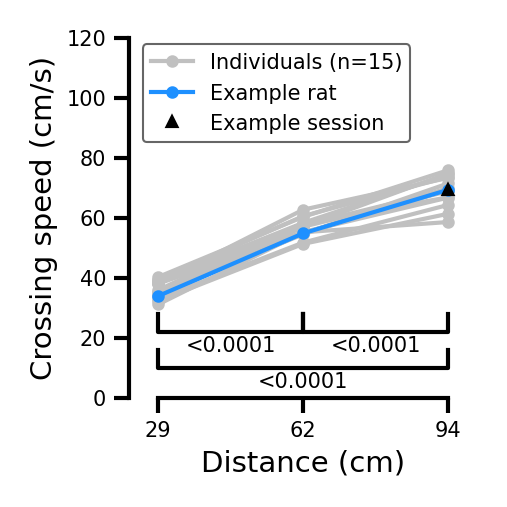

In [14]:
def Figure2I(ax=None):
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(5, 5))

    conds = ["60", "90", "120"]
    run_speeds = {k: {a: [] for a in conds} for k in animalList}
    run_speeds2 = {k: {a: [] for a in conds} for k in animalList}

    for cond, sessionlist in zip(conds, [dist60, dist90, dist120]):
        for animal in animalList:
            for session in matchsession(animal, sessionlist):
                params = get_from_pickle(root, animal, session, name="params.p")
                for elem in sequence[animal, session]:
                    if get_block(sequence[animal, session][elem][0]) <= 1:
                        if sequence[animal, session][elem][1] == 'run':
                            tm_speed = params['treadmillSpeed'][get_block(sequence[animal, session][elem][0])]
                            run_speeds[animal][cond].append(abs(sequence[animal, session][elem][-1]) - tm_speed)

    for animal in animalList:
        for cond in conds:
            run_speeds2[animal][cond] = np.median(run_speeds[animal][cond])

    
    # effect_of_condition(run_speeds2, conds=['60', '90', '120'], name='runspeed')

    for animal in animalList:
        ax.plot([0, 1, 2], [np.median(run_speeds[animal][cond]) for cond in conds], color=rat_markers[animal][0],
                marker=rat_markers[animal][1], markersize=2, label=f'Individuals (n={len(animalList)})')

        if animal == "RatM00":
            pickle.dump([np.median(run_speeds[animal][cond]) for cond in conds], open("picklejar/example_rat_run_speeds_dist.p", "wb"))
            ax.plot([0, 1, 2], [np.median(run_speeds[animal][cond]) for cond in conds], color=rat_markers[animal][0],
                    marker=rat_markers[animal][1], markersize=2, zorder=10, label='Example rat')

    animal='RatM00'
    session='RatM00_2021_07_22_16_13_03'
    example_session_run_speeds = []
    params = get_from_pickle(root, animal, session, name="params.p")
    for elem in sequence[animal, session]:
        if get_block(sequence[animal, session][elem][0]) <= 1:
            if sequence[animal, session][elem][1] == 'run':
                tm_speed = params['treadmillSpeed'][get_block(sequence[animal, session][elem][0])]
                example_session_run_speeds.append(abs(sequence[animal, session][elem][-1]) - tm_speed)

    ax.plot(2, np.median(example_session_run_speeds), color='black', marker='^', zorder=10, markersize=2, linewidth=0, label='Example session')
    ax.set_xlim(0, 2)
    ax.set_xticks([0, 1, 2])
    ax.set_xticklabels(["29", "62", "94"])
    ax.set_xlabel("Distance (cm)")


    ax.set_ylim(0, 120)
    ax.set_yticks([0, 20, 40, 60, 80, 100, 120])
    ax.set_ylabel("Crossing speed (cm/s)")
    plotmedian(run_speeds2, ax=ax, dist_or_tm='dist')

    handles, labels = ax.get_legend_handles_labels()
    unique = [(h, l) for i, (h, l) in enumerate(zip(handles, labels)) if l not in labels[:i]]
    ax.legend(*zip(*unique), loc='upper left', bbox_to_anchor=(0.01, 1.01), 
                                frameon=True, fontsize=5, markerscale=1, 
                                edgecolor='k', facecolor='w', 
                                # title='Legend for all figures:     ', title_fontsize=5
                                ).get_frame().set_linewidth(.5)


    permutation_test_distances(run_speeds2, ax=ax, shifty=.025, num_permutations=10000)
    space_axes(ax, y_ratio=0, x_ratio_left=.1, x_ratio_right=.1)
    

fig, ax = plt.subplots(1, 1, figsize=(cm2inch(4), cm2inch(4)))
Figure2I(ax=ax)

# 2J schematic vbelt

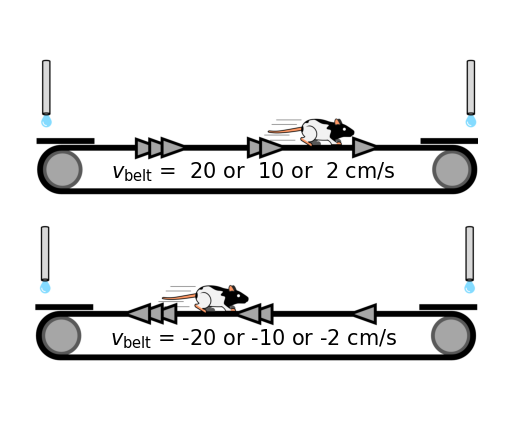

In [15]:
def Figure2J(ax=None, path=None):
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(5, 5))

    if path is None:
        path = "/home/david/Desktop/code/Figures/2Erun.png"

    img = plt.imread(path)
    img = img[:, 150:3075]
    ax.imshow(img)
    ax.axis("off")
    ax.text(s=r'$v_{\mathrm{belt}}$ =  20 or  10 or  2 cm/s', x=img.shape[1]/2, y=930, ha="center", va="center", fontsize=5)
    ax.text(s=r'$v_{\mathrm{belt}}$ = -20 or -10 or -2 cm/s', x=img.shape[1]/2, y=2020, ha="center", va="center", fontsize=5)

fig, ax = plt.subplots(1, 1, figsize=(cm2inch(4), cm2inch(4)))
Figure2J(ax=ax)

# 2KLM fit results vbelt

p_value_20_0: 0.5834 p_value_0_rev20: 0.0007 p_value_20_rev20: 0.0135
p_value_20_0: 0.0317 p_value_0_rev20: 0.0714 p_value_20_rev20: 0.605
p_value_20_0: 0.1299 p_value_0_rev20: 0.9157 p_value_20_rev20: 0.1422


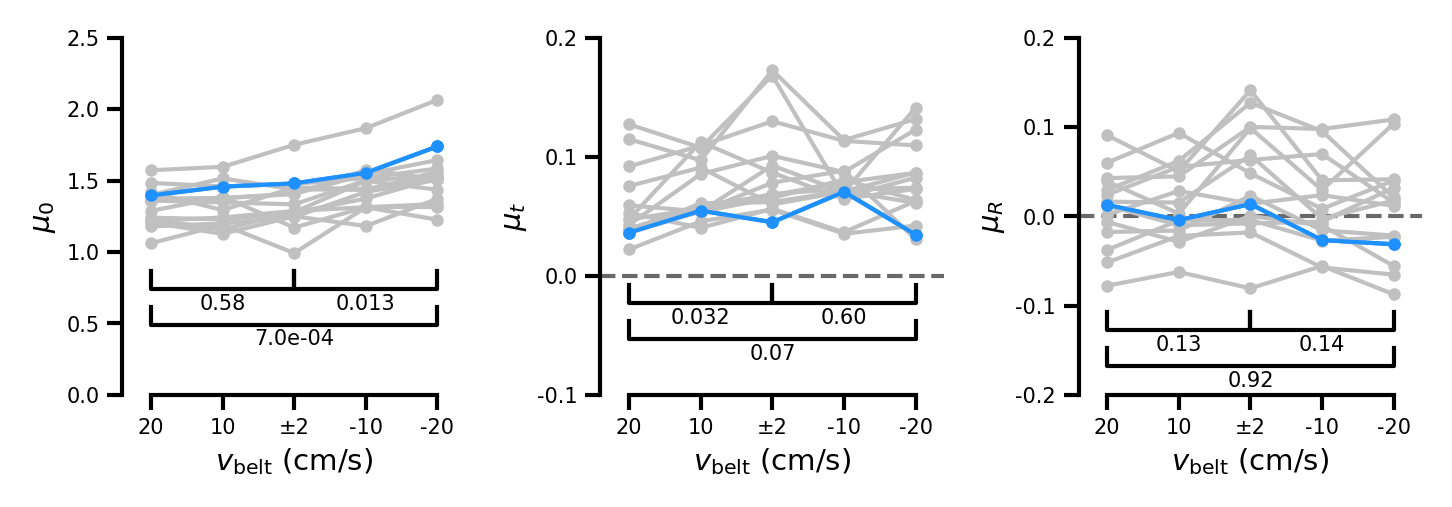

In [16]:
def Figure2K(ax=None):
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(5, 5))

    _, _, _, _, _, _, mu_0, _, _, _, _, _ = pickle.load(open("picklejar/intact_lesionFITS.p", "rb"))

    for animal in animalList:
        ax.plot([0, 1, 2, 3, 4], [mu_0[animal]["20"], mu_0[animal]["10"], mu_0[animal]["2"], mu_0[animal]["rev10"], mu_0[animal]["rev20"]], 
                        color=rat_markers[animal][0], label=animal, marker=rat_markers[animal][1], 
                        markersize=2, linestyle=lines[brainstatus[animal]])
    
        if animal == "RatM00":
            ax.plot([0, 1, 2, 3, 4], [mu_0[animal]["20"], mu_0[animal]["10"], mu_0[animal]["2"], mu_0[animal]["rev10"], mu_0[animal]["rev20"]], 
                        color=rat_markers[animal][0], label=animal, marker=rat_markers[animal][1], 
                        markersize=2, linestyle=lines[brainstatus[animal]], zorder=10)
    
    ax.set_xlim(0, 4)
    ax.set_xticks([0, 1, 2, 3, 4])
    ax.set_xticklabels(["20", "10", "±2", "-10", "-20"])
    _ = r'$v_{\mathrm{belt}}$'
    ax.set_xlabel(f'{_} (cm/s)')

    ax.set_ylim(0, 2.5)
    ax.set_ylabel(r'$\mu_0$')
    # ax.axhline(0, color='black', linestyle='--', linewidth=1, alpha=0.5, zorder=0)
    space_axes(ax, y_ratio=0, x_ratio_left=.1, x_ratio_right=.1)
    plotmedian(mu_0, ax=ax, dist_or_tm='tm')
    permutation_test_vbelt(mu_0, ax=ax, num_permutations=10000)

def Figure2L(ax=None):
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(5, 5))

    _, _, _, _, _, _, _, mu_t, _, _, _, _ = pickle.load(open("picklejar/intact_lesionFITS.p", "rb"))

    for animal in animalList:
        ax.plot([0, 1, 2, 3, 4], [mu_t[animal]["20"], mu_t[animal]["10"], mu_t[animal]["2"], mu_t[animal]["rev10"], mu_t[animal]["rev20"]], 
                        color=rat_markers[animal][0], label=animal, marker=rat_markers[animal][1], 
                        markersize=2, linestyle=lines[brainstatus[animal]])
        if animal == "RatM00":
            ax.plot([0, 1, 2, 3, 4], [mu_t[animal]["20"], mu_t[animal]["10"], mu_t[animal]["2"], mu_t[animal]["rev10"], mu_t[animal]["rev20"]], 
                        color=rat_markers[animal][0], label=animal, marker=rat_markers[animal][1], 
                        markersize=2, linestyle=lines[brainstatus[animal]], zorder=10)

    ax.set_xlim(0, 4)
    ax.set_xticks([0, 1, 2, 3, 4])
    ax.set_xticklabels(["20", "10", "±2", "-10", "-20"])
    _ = r'$v_{\mathrm{belt}}$'
    ax.set_xlabel(f'{_} (cm/s)')

    ax.set_ylim(-.1, .2)
    ax.set_yticks([-.1, 0, .1, .2])
    ax.set_ylabel(r'$\mu_t$')
    ax.axhline(0, color='dimgray', linestyle='--', linewidth=1, alpha=1, zorder=0)
    space_axes(ax, y_ratio=0, x_ratio_left=.1, x_ratio_right=.1)
    plotmedian(mu_t, ax=ax, dist_or_tm='tm')
    permutation_test_vbelt(mu_t, ax=ax, shifty=-.05, num_permutations=10000)

def Figure2M(ax=None):
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(5, 5))

    _, _, _, _, _, _, _, _, mu_R, _, _, _ = pickle.load(open("picklejar/intact_lesionFITS.p", "rb"))

    for animal in animalList:
        ax.plot([0, 1, 2, 3, 4], [mu_R[animal]["20"], mu_R[animal]["10"], mu_R[animal]["2"], mu_R[animal]["rev10"], mu_R[animal]["rev20"]], 
                        color=rat_markers[animal][0], label=animal, marker=rat_markers[animal][1], 
                        markersize=2, linestyle=lines[brainstatus[animal]])
        if animal == "RatM00":
            ax.plot([0, 1, 2, 3, 4], [mu_R[animal]["20"], mu_R[animal]["10"], mu_R[animal]["2"], mu_R[animal]["rev10"], mu_R[animal]["rev20"]], 
                        color=rat_markers[animal][0], label=animal, marker=rat_markers[animal][1], 
                        markersize=2, linestyle=lines[brainstatus[animal]], zorder=10)
    
    ax.set_xlim(0, 4)
    ax.set_xticks([0, 1, 2, 3, 4])
    ax.set_xticklabels(["20", "10", "±2", "-10", "-20"])
    _ = r'$v_{\mathrm{belt}}$'
    ax.set_xlabel(f'{_} (cm/s)')

    ax.set_ylim(-.2, .2)
    ax.set_yticks([-.2, -.1, 0, .1, .2])
    ax.set_ylabel(r'$\mu_R$')
    ax.axhline(0, color='dimgray', linestyle='--', linewidth=1, alpha=1, zorder=0)
    space_axes(ax, y_ratio=0, x_ratio_left=.1, x_ratio_right=.1)
    plotmedian(mu_R, ax=ax, dist_or_tm='tm')
    permutation_test_vbelt(mu_R, ax=ax, num_permutations=10000)

fig, axs = plt.subplots(1, 3, figsize=(cm2inch(12), cm2inch(4)))
Figure2K(axs[0])
Figure2L(axs[1])
Figure2M(axs[2])

# 2N mean run speed vbelt

p_value_20_0: 0.0 p_value_0_rev20: 0.0 p_value_20_rev20: 0.0


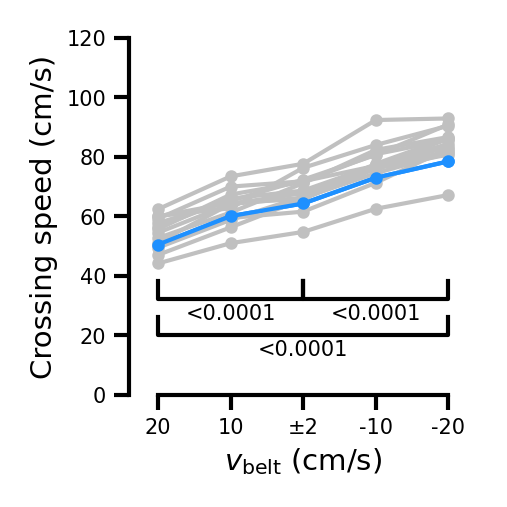

In [17]:
def Figure2N(ax=None):
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(5, 5))

    conds = ["20", "10", "2", "rev10", "rev20"]
    run_speeds = {k: {a: [] for a in conds} for k in animalList}
    run_speeds2 = {k: {a: [] for a in conds} for k in animalList}

    for cond, sessionlist in zip(conds, [TM20, TM10, TM2, TMrev10, TMrev20]):
        for animal in animalList:
            for session in matchsession(animal, sessionlist):
                params = get_from_pickle(root, animal, session, name="params.p")
                for elem in sequence[animal, session]:
                    if get_block(sequence[animal, session][elem][0]) <= 1:
                        if sequence[animal, session][elem][1] == 'run':
                            tm_speed = params['treadmillSpeed'][get_block(sequence[animal, session][elem][0])]
                            run_speeds[animal][cond].append(abs(sequence[animal, session][elem][-1]) - tm_speed)

    for animal in animalList:
        for cond in conds:
            run_speeds2[animal][cond] = np.median(run_speeds[animal][cond])

    # effect_of_condition(run_speeds2, conds=conds, name='runspeed')
    # plotmedian(run_speeds2, ax=ax, dist_or_tm='tm')

    for animal in animalList:
        ax.plot([0, 1, 2, 3, 4], [np.median(run_speeds[animal][cond]) for cond in conds], color=rat_markers[animal][0],
                marker=rat_markers[animal][1], markersize=2)
        
        if animal == 'RatM00':
            pickle.dump([np.median(run_speeds[animal][cond]) for cond in conds], open("picklejar/example_rat_run_speeds_tm.p", "wb"))
            ax.plot([0, 1, 2, 3, 4], [np.median(run_speeds[animal][cond]) for cond in conds], color=rat_markers[animal][0],
                marker=rat_markers[animal][1], markersize=2, zorder=10)
                
    ax.set_xlim(0, 4)
    ax.set_xticks([0, 1, 2, 3, 4])
    ax.set_xticklabels(["20", "10", "±2", "-10", "-20"])
    _ = r'$v_{\mathrm{belt}}$'
    ax.set_xlabel(f'{_} (cm/s)')

    ax.set_ylim(0, 120)
    ax.set_yticks([0, 20, 40, 60, 80, 100, 120])
    ax.set_ylabel("Crossing speed (cm/s)")

    permutation_test_vbelt(run_speeds2, ax=ax, num_permutations=10000)
    space_axes(ax, y_ratio=0, x_ratio_left=.1, x_ratio_right=.1)

fig, ax = plt.subplots(1, 1, figsize=(cm2inch(4), cm2inch(4)))
Figure2N(ax=ax)

# Figure 2

1.3731192071741753 0.0612856829746447 0.00633329065966956 0.0 0.0 0.0
p_value_60_90: 0.0 p_value_60_120: 0.0 p_value_90_120: 0.0
p_value_60_90: 0.0021 p_value_60_120: 0.028 p_value_90_120: 0.8646
p_value_60_90: 0.1181 p_value_60_120: 0.2965 p_value_90_120: 0.9865
p_value_60_90: 0.0 p_value_60_120: 0.0 p_value_90_120: 0.0
p_value_20_0: 0.5973 p_value_0_rev20: 0.0012 p_value_20_rev20: 0.0112
p_value_20_0: 0.0328 p_value_0_rev20: 0.0747 p_value_20_rev20: 0.6065
p_value_20_0: 0.1319 p_value_0_rev20: 0.913 p_value_20_rev20: 0.1495
p_value_20_0: 0.0 p_value_0_rev20: 0.0 p_value_20_rev20: 0.0


Text(0.5, 1, '$\\mu(t, R) = \\mu_0 + \\mu_t t + \\mu_R R$')

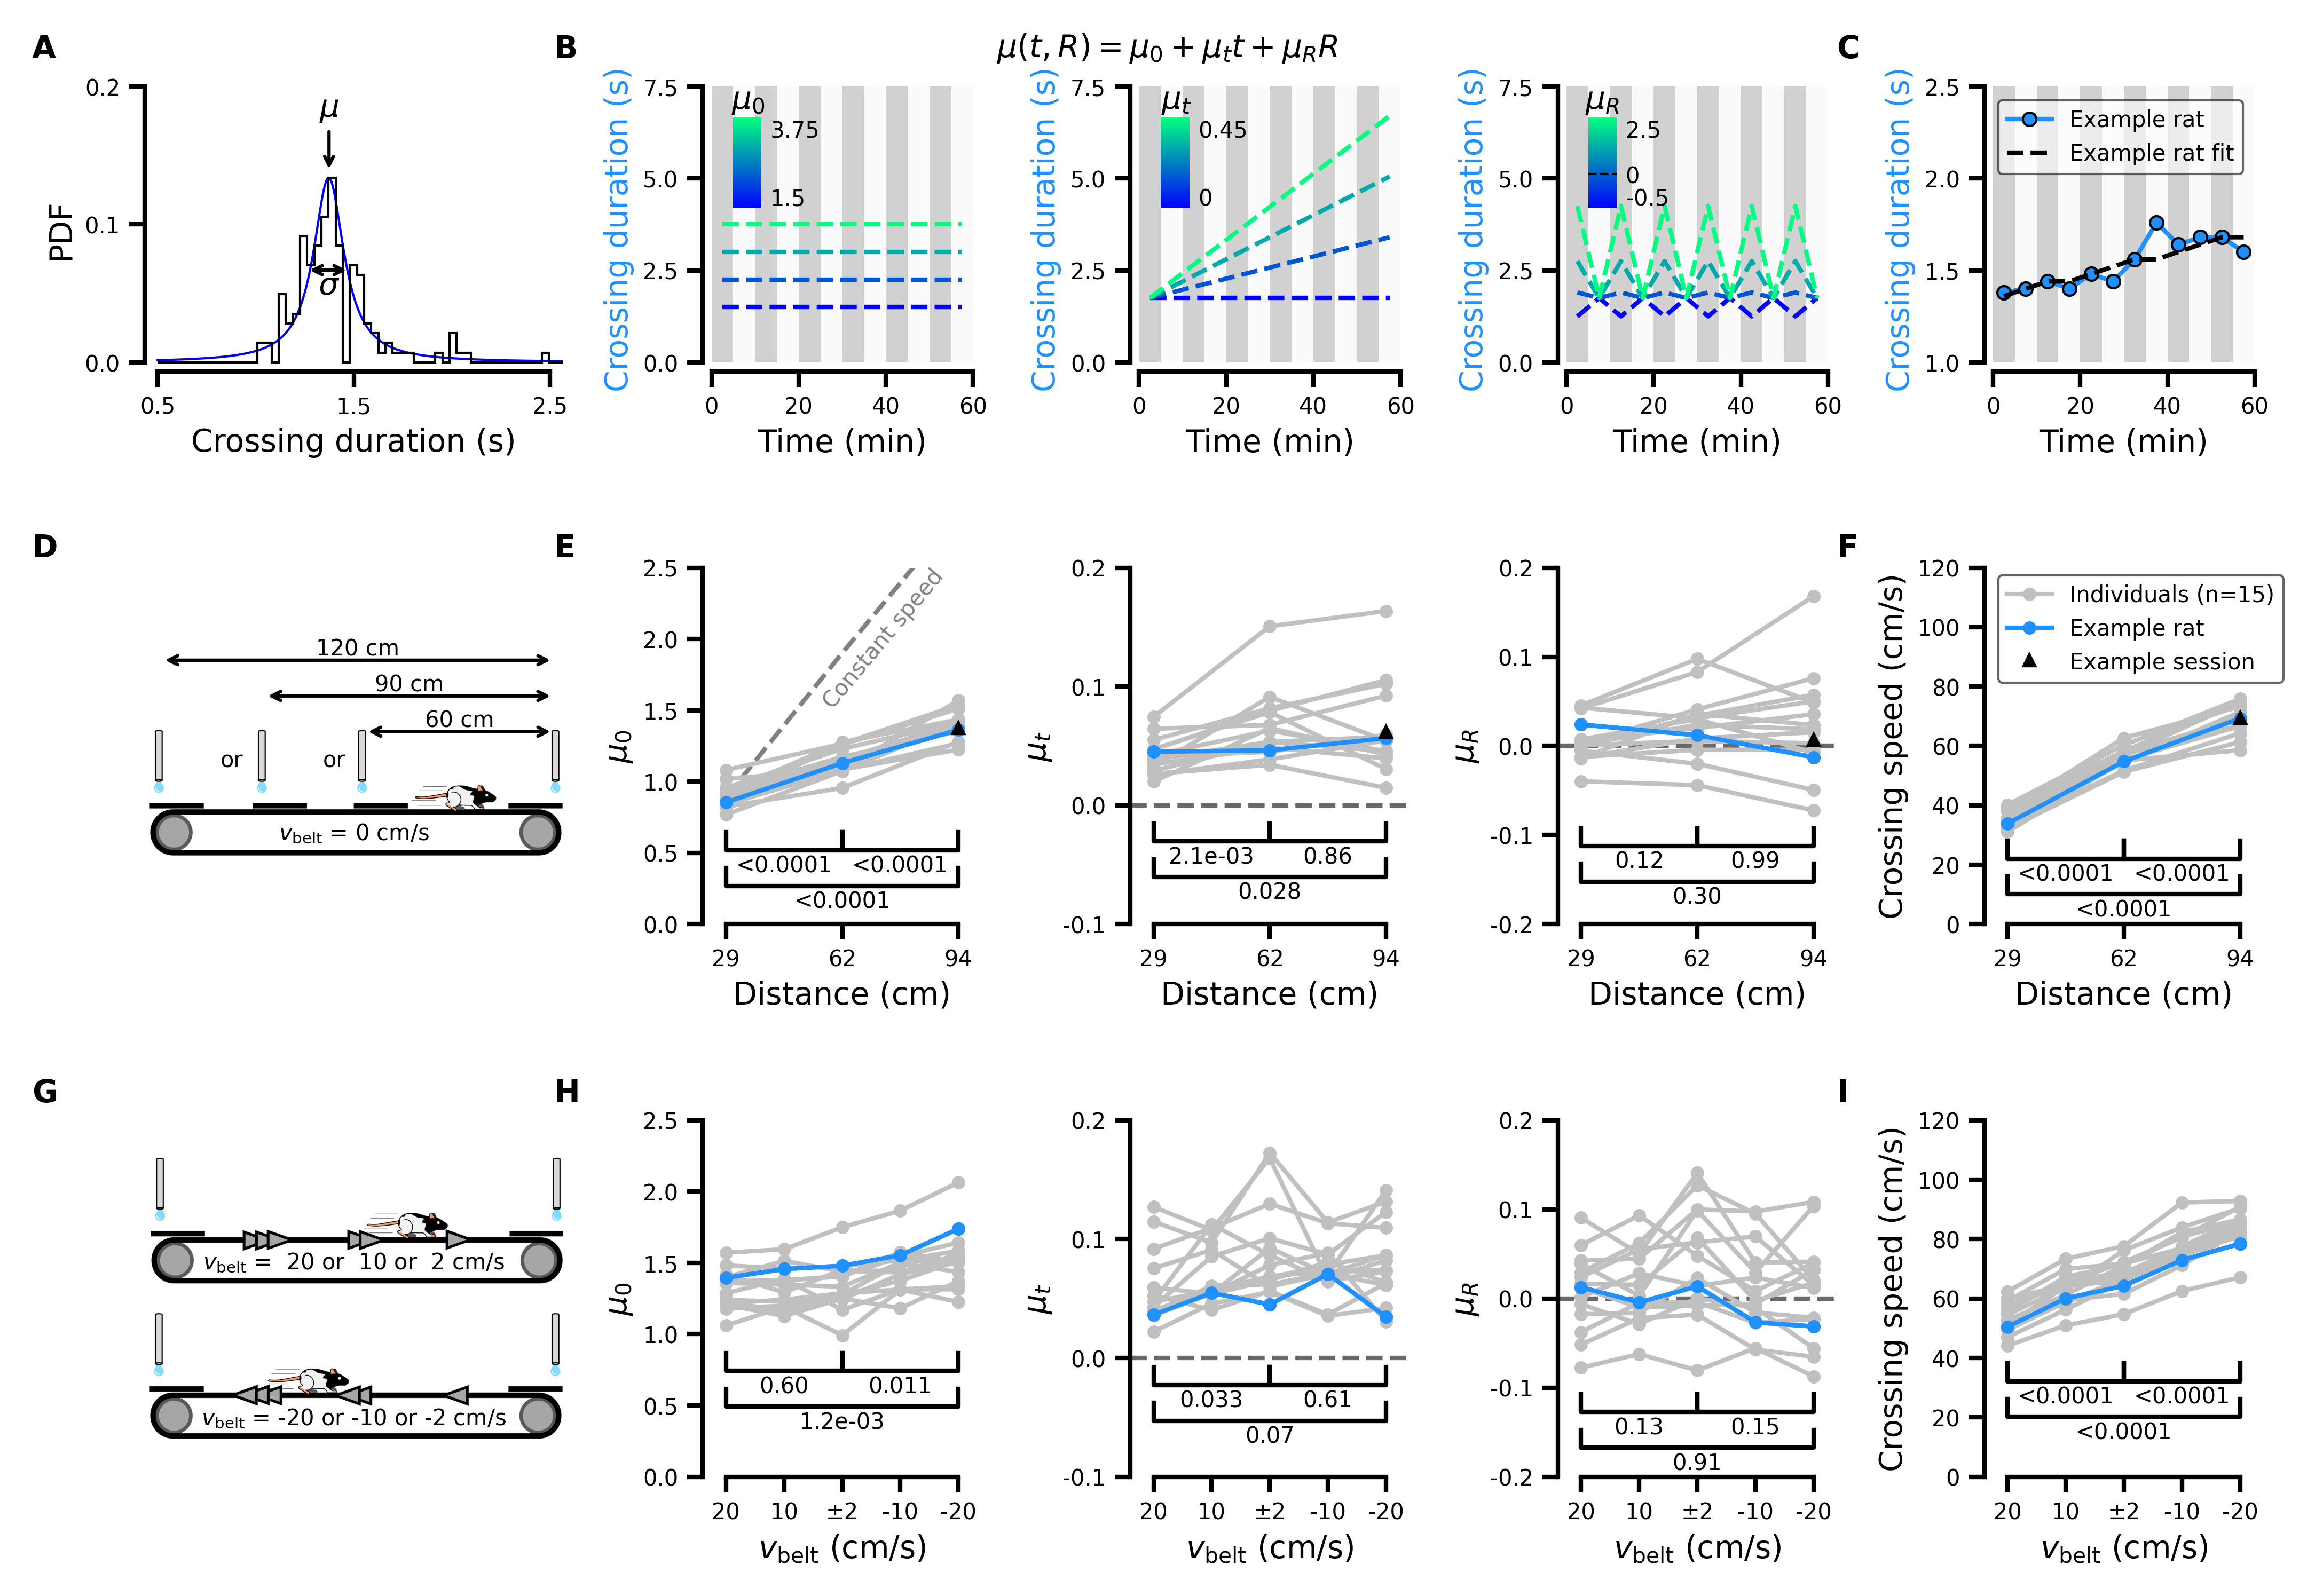

In [18]:

fig = plt.figure(figsize=(cm2inch(18), cm2inch(12)), constrained_layout=True, facecolor='w', dpi=600)

gs0 = fig.add_gridspec(5, 5, wspace=.5, hspace=.5, 
                       height_ratios=[8, 1, 10, 1, 10], width_ratios=[3, 2, 2, 2, 2])


explanation_mu = plt.subplot(gs0[0, 0])
explanation_mu_0 = plt.subplot(gs0[0, 1])
explanation_mu_t = plt.subplot(gs0[0, 2])
explanation_mu_R = plt.subplot(gs0[0, 3])
modeldata = plt.subplot(gs0[0, 4])

schematic_distances = plt.subplot(gs0[2, 0])
fit_mu_0_distance = plt.subplot(gs0[2, 1])
fit_mu_t_distance = plt.subplot(gs0[2, 2])
fit_mu_R_distance = plt.subplot(gs0[2, 3])
speed_distance = plt.subplot(gs0[2, 4])

schematic_vbelts = plt.subplot(gs0[4, 0])
fit_mu_0_vbelt = plt.subplot(gs0[4, 1])
fit_mu_t_vbelt = plt.subplot(gs0[4, 2])
fit_mu_R_vbelt = plt.subplot(gs0[4, 3])
speed_vbelt = plt.subplot(gs0[4, 4])



plot_mu(explanation_mu)
Figure2A(ax=explanation_mu_0)
Figure2B(ax=explanation_mu_t)
Figure2C(ax=explanation_mu_R)
Figure2D(ax=modeldata)

Figure2E(ax=schematic_distances)
Figure2F(ax=fit_mu_0_distance)
Figure2G(ax=fit_mu_t_distance)
Figure2H(ax=fit_mu_R_distance)
Figure2I(ax=speed_distance)

Figure2J(ax=schematic_vbelts)
Figure2K(ax=fit_mu_0_vbelt)
Figure2L(ax=fit_mu_t_vbelt)
Figure2M(ax=fit_mu_R_vbelt)
Figure2N(ax=speed_vbelt)


figuresLabels={"A":[0.00, 1.00], "B":[0.23, 1.00], "C":[0.795, 1.00],
               "D":[0.00, 0.67], "E":[0.23, 0.67], "F":[0.795, 0.67], 
                "G":[0.00, 0.31], "H":[0.23, 0.31], "I":[0.795, 0.31],
               }

for label,coordinates in sorted(figuresLabels.items()):
    fig.text(coordinates[0], coordinates[1],
             label, figure=fig, 
             weight='bold', fontsize=7, ha='left', va='bottom')
    
h, w = 0.06, 0.0125

cbarA = fig.add_axes([.3087, .905, w, h])
plot_colorbar(ax=cbarA, label=r'$\mu_0$', cmap='winter', labels=[1.5, 0, 3.75], labelpad=-16)

cbarB = fig.add_axes([.49728, .905, w, h])
plot_colorbar(ax=cbarB, label=r'$\mu_t$', cmap='winter', labels=[0, 0, .45], labelpad=-16)

cbarC = fig.add_axes([.6855, .905, w, h])
plot_colorbar(ax=cbarC, label=r'$\mu_R$', show_zero=150, cmap='winter', labels=[-0.5, 0, 2.5], labelpad=-15)


plt.text(s=r'$\mu(t, R) = \mu_0 + \mu_t t + \mu_R R$', 
         x=0.5, y=1, ha="center", va="bottom", fontsize=7, 
        #  bbox=dict(facecolor='none', edgecolor='k', alpha=1, boxstyle='round, pad=.25', linewidth=.5), 
         transform=plt.gcf().transFigure)


# plt.savefig("/home/david/Desktop/code/Figure_2.pdf", facecolor='w', 
#         edgecolor='none', bbox_inches='tight', format="pdf", dpi=600)

In [19]:
<

SyntaxError: invalid syntax (4056019114.py, line 1)

In [ ]:
# def effort_cost(T, D=1, alpha=1, vbelt=0):
#     return alpha * ((D**2 / T) - 2*vbelt*D + vbelt**2 * T)

def effort_cost(T, D=1, alpha=1, vbelt=0, power_effort=1):
    np.seterr(divide='ignore', invalid='ignore')
    vmax = (D - vbelt * T) / (T)
    return alpha * T * (vmax ** power_effort)

def time_cost(T, beta=1, power_time=1):
    return beta*T ** power_time


def plot_model(D=1, vbelt=0, alpha=1, beta=1, power_effort=2, power_time=3):
    fig, ax = plt.subplots(1, 1, figsize=(2, 2))
    T = np.linspace(0, 2, 100)
    ax.plot(T, effort_cost(T, D, alpha, vbelt, power_effort), label=r'$C_v$', color='r')
    ax.plot(T, time_cost(T, beta, power_time), label=r'$C_t$', color='g')
    ax.plot(T, effort_cost(T, D, alpha, vbelt, power_effort) + time_cost(T, beta, power_time), label=r'$C_v + C_t$', color='k')
    # argmin of total cost
    ax.plot(T[np.nanargmin(effort_cost(T, D, alpha, vbelt, power_effort) + time_cost(T, beta, power_time))], 
            np.nanmin(effort_cost(T, D, alpha, vbelt, power_effort) + time_cost(T, beta, power_time)),
            'o', color='k')#, label=r'$T^*$')

    ax.set_xlabel('Crossing duration (s)')
    ax.set_ylabel('Cost (a.u.)')
    ax.legend()
    ax.set_ylim(-.5, 5)
    ax.set_xlim(-.25, 2.25)
    topt = T[np.nanargmin(effort_cost(T, D, alpha, vbelt, power_effort) + time_cost(T, beta, power_time))]
    ax.set_xticks([0, topt, 1, 2])
    ax.set_xticklabels([0, r'$T_{opt}$', 1, 2])

    ax.spines['left'].set_bounds(0, 5)
    ax.spines['bottom'].set_bounds(0, 2)


interactive_plot = interactive(plot_model, D=(0, 2, .1), vbelt=(-.2, .2, 0.01), 
alpha=(0, 50.0, 0.5), beta=(0, 5, 0.5), 
power_effort=(0, 5, 0.1), power_time=(0, 5, 0.1))
interactive_plot

interactive(children=(FloatSlider(value=1.0, description='D', max=2.0), FloatSlider(value=0.0, description='vb…

# suppl

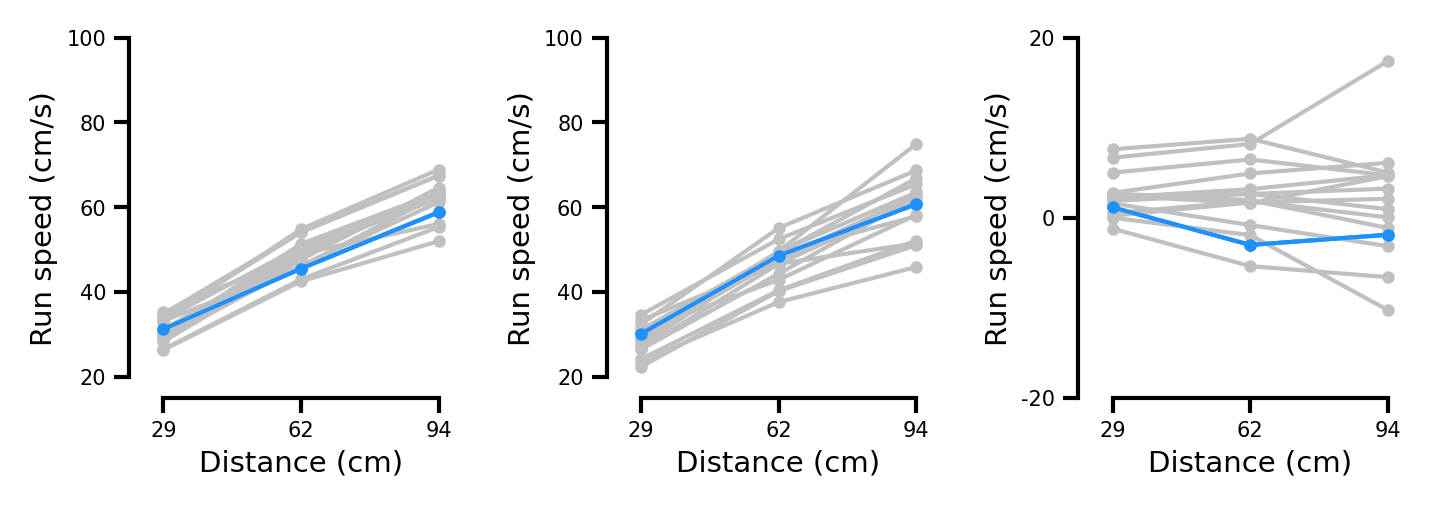

In [ ]:
def FigureS2I(axs=None):
    if axs is None:
        fig, axs = plt.subplots(1, 2, figsize=(10, 5))

    conds = ["60", "90", "120"]
    run_speeds90 = {k: {a: [] for a in animalList} for k in conds}
    run_speeds10 = {k: {a: [] for a in animalList} for k in conds}

    for cond, sessionlist in zip(conds, [dist60, dist90, dist120]):
        for animal in animalList:
            for session in matchsession(animal, sessionlist):
                params = get_from_pickle(root, animal, session, name="params.p")
                for elem in sequence[animal, session]:
                    if sequence[animal, session][elem][1] == 'run':
                        tm_speed = params['treadmillSpeed'][get_block(sequence[animal, session][elem][0])]
                        if get_block(sequence[animal, session][elem][0]) %2 == 0:
                            run_speeds90[cond][animal].append(abs(sequence[animal, session][elem][-1]) - tm_speed)
                        else:
                            run_speeds10[cond][animal].append(abs(sequence[animal, session][elem][-1]) - tm_speed)


    for animal in animalList:
        axs[0].plot([0, 1, 2], [np.median(run_speeds90[cond][animal]) for cond in conds], color=rat_markers[animal][0],
                marker=rat_markers[animal][1], markersize=2)
        axs[1].plot([0, 1, 2], [np.median(run_speeds10[cond][animal]) for cond in conds], color=rat_markers[animal][0],
                marker=rat_markers[animal][1], markersize=2)

        axs[2].plot([0, 1, 2], [np.median(run_speeds90[cond][animal]) - np.median(run_speeds10[cond][animal]) for cond in conds], color=rat_markers[animal][0],
                marker=rat_markers[animal][1], markersize=2)

        if animal == "RatM00":
            axs[0].plot([0, 1, 2], [np.median(run_speeds90[cond][animal]) for cond in conds], color=rat_markers[animal][0],
                    marker=rat_markers[animal][1], markersize=2, zorder=10)
            axs[1].plot([0, 1, 2], [np.median(run_speeds10[cond][animal]) for cond in conds], color=rat_markers[animal][0],
                    marker=rat_markers[animal][1], markersize=2, zorder=10)
            
            axs[2].plot([0, 1, 2], [np.median(run_speeds90[cond][animal]) - np.median(run_speeds10[cond][animal]) for cond in conds], color=rat_markers[animal][0],
                    marker=rat_markers[animal][1], markersize=2, zorder=10)



    # animal='RatF02'
    # session='RatF02_2021_07_22_18_14_16'
    # example_session_run_speeds = []
    # params = get_from_pickle(root, animal, session, name="params.p")
    # for elem in sequence[animal, session]:
    #     if sequence[animal, session][elem][1] == 'run':
    #         tm_speed = params['treadmillSpeed'][get_block(sequence[animal, session][elem][0])]
    #         example_session_run_speeds.append(abs(sequence[animal, session][elem][-1]) - tm_speed)

    # ax.plot(2, np.median(example_session_run_speeds), color='black', marker='^', zorder=10, markersize=2, linewidth=0)

    for ax in axs:
        ax.set_xlim(-0.25, 2.25)
        ax.set_xticks([0, 1, 2])
        ax.set_xticklabels(["29", "62", "94"])
        ax.set_xlabel("Distance (cm)")


        ax.set_ylim(15, 100)
        ax.set_yticks([20, 40, 60, 80, 100])
        ax.set_ylabel("Run speed (cm/s)")


        ax.spines['left'].set_bounds(20, 100)
        ax.spines['bottom'].set_bounds(0, 2)

    axs[2].set_ylim(-20, 20)
    axs[2].spines['left'].set_bounds(-20, 20)
    axs[2].set_yticks([-20, 00, 20])

fig, axs = plt.subplots(1, 3, figsize=(cm2inch(12), cm2inch(4)))
FigureS2I(axs=axs)

[39.58839798912963, 56.94630658669116, 74.03565885278887]


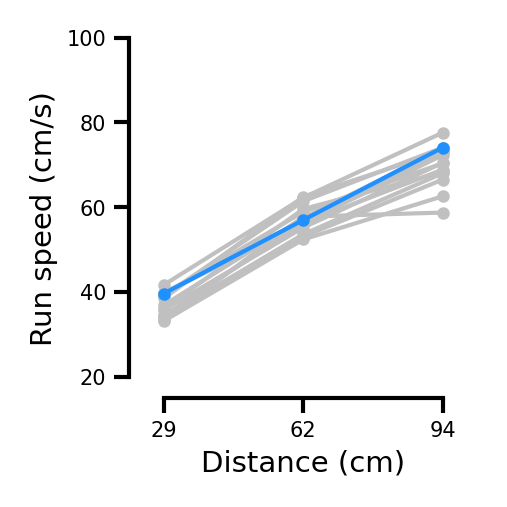

In [ ]:
def Figure2I(ax=None):
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(5, 5))

    conds = ["60", "90", "120"]
    run_speeds = {k: {a: [] for a in animalList} for k in conds}

    for cond, sessionlist in zip(conds, [dist60, dist90, dist120]):
        for animal in animalList:
            for session in matchsession(animal, sessionlist):
                params = get_from_pickle(root, animal, session, name="params.p")
                for elem in sequence[animal, session]:
                    if get_block(sequence[animal, session][elem][0]) == 0:

                        if sequence[animal, session][elem][1] == 'run':
                            tm_speed = params['treadmillSpeed'][get_block(sequence[animal, session][elem][0])]
                            run_speeds[cond][animal].append(abs(sequence[animal, session][elem][-1]) - tm_speed)


    for animal in animalList:
        ax.plot([0, 1, 2], [np.median(run_speeds[cond][animal]) for cond in conds], color=rat_markers[animal][0],
                marker=rat_markers[animal][1], markersize=2)

        if animal == "RatM00":
            print([np.median(run_speeds[cond][animal]) for cond in conds])
            ax.plot([0, 1, 2], [np.median(run_speeds[cond][animal]) for cond in conds], color=rat_markers[animal][0],
                    marker=rat_markers[animal][1], markersize=2, zorder=10)


    ax.set_xlim(-0.25, 2.25)
    ax.set_xticks([0, 1, 2])
    ax.set_xticklabels(["29", "62", "94"])
    ax.set_xlabel("Distance (cm)")


    ax.set_ylim(15, 100)
    ax.set_yticks([20, 40, 60, 80, 100])
    ax.set_ylabel("Run speed (cm/s)")


    ax.spines['left'].set_bounds(20, 100)
    ax.spines['bottom'].set_bounds(0, 2)

fig, ax = plt.subplots(1, 1, figsize=(cm2inch(4), cm2inch(4)))
Figure2I(ax=ax)